# Overview

# Imports

In [115]:
import numpy as np
from scipy.stats import norm, poisson
from scipy.interpolate import InterpolatedUnivariateSpline
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import multiprocessing
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

from plot_config import config_plots

In [122]:
config_plots()

In [124]:
#plt.rcParams['text.usetex'] = False

In [123]:
plt.rcParams['text.usetex']

True

# Figure 1
- Sensitivity optimization: mean vs. median

In [74]:
#bs = np.arange(0.01, 0.51, 0.01) # shifted
#bs = np.arange(0.005, 0.505, 0.01) # agreement
bs = np.arange(0.005, 0.496, 0.001) # fine-tuned (~45 s to run)

In [38]:
bs

array([0.005, 0.006, 0.007, 0.008, 0.009, 0.01 , 0.011, 0.012, 0.013,
       0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02 , 0.021, 0.022,
       0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03 , 0.031,
       0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038, 0.039, 0.04 ,
       0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049,
       0.05 , 0.051, 0.052, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058,
       0.059, 0.06 , 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067,
       0.068, 0.069, 0.07 , 0.071, 0.072, 0.073, 0.074, 0.075, 0.076,
       0.077, 0.078, 0.079, 0.08 , 0.081, 0.082, 0.083, 0.084, 0.085,
       0.086, 0.087, 0.088, 0.089, 0.09 , 0.091, 0.092, 0.093, 0.094,
       0.095, 0.096, 0.097, 0.098, 0.099, 0.1  , 0.101, 0.102, 0.103,
       0.104, 0.105, 0.106, 0.107, 0.108, 0.109, 0.11 , 0.111, 0.112,
       0.113, 0.114, 0.115, 0.116, 0.117, 0.118, 0.119, 0.12 , 0.121,
       0.122, 0.123, 0.124, 0.125, 0.126, 0.127, 0.128, 0.129, 0.13 ,
       0.131, 0.132,

In [43]:
ss = np.linspace(1, 11, 20)
#ss_med = np.linspace(1, 11, 1001)
ss_med = np.linspace(1, 11, 101)
ks = np.arange(0, 20, 1)

In [48]:
P5s = norm.sf(5, loc=0, scale=1)

In [152]:
def meanNsigma(b, s, ks): 
    ps = poisson.pmf(k=ks, mu=s+b) 
    # match
    #sigmas = np.array([norm.isf(poisson.sf(k=k_-1, mu=b), loc=0, scale=1) 
    #                   if k_ > 0 else norm.isf(poisson.sf(k=0, mu=b), loc=0, scale=1) for k_ in ks])
    # 0 sigma
    sigmas = np.array([norm.isf(poisson.sf(k=k_-1, mu=b), loc=0, scale=1) 
                      if k_ > 0 else 0. for k_ in ks])
    return np.sum(ps*sigmas)/np.sum(ps)

def get_s_5sigma_mean(b, ks=ks, ss=ss): 
    meanNsigs = np.array([meanNsigma(b, s_, ks) for s_ in ss]) 
    s5 = InterpolatedUnivariateSpline(ss, meanNsigs - 5).roots()[0] 
    return s5

def get_s_5sigma_med(b, ss_med=ss_med):
    s = 0
    n = s+b
    ndisc = poisson.isf(P5s, mu=n)+1
    sfs = poisson.sf(k=ndisc-1, mu=ss_med+b)
#     s_med = ss_med[np.argmin(abs(sfs-0.5))]
    s_med = InterpolatedUnivariateSpline(ss_med, sfs-0.5).roots()[0]
    return s_med

def calc_mean_med_5sigma(b, ks=ks, ss=ss, ss_med=ss_med): 
#     s = 0 
#     n = s + b 
    s_mean = get_s_5sigma_mean(b, ks, ss) 
#     ndisc = poisson.isf(P5s, mu=n)+1 
#     sfs = poisson.sf(k=ndisc-1, mu=ss_med+b) 
#     s_med = ss_med[np.argmin(abs(sfs-0.5))] 
    s_med = get_s_5sigma_med(b, ss_med)
    return s_mean, s_med 

# parallel
def parallel_5sigma(bs=bs, ks=ks, ss=ss, ss_med=ss_med):
    # parallel processing
    num_cpu = multiprocessing.cpu_count()
    njs = min([num_cpu, len(bs)])
    print(f'N_jobs = {njs}; cpu_count = {num_cpu}')
    # parallel for loop
    calc_tuples = Parallel(n_jobs=njs)(delayed(calc_mean_med_5sigma)(b_, ks, ss, ss_med) for b_ in tqdm(bs, desc='mu(b) index'))
    s_means = np.array([i[0] for i in calc_tuples])
    s_meds = np.array([i[1] for i in calc_tuples])
    return s_means, s_meds
    

In [75]:
%%time
# single process
s_means, s_meds = np.array([calc_mean_med_5sigma(b_, ks, ss, ss_med) for b_ in bs]).T 

CPU times: user 31.7 s, sys: 13.8 ms, total: 31.7 s
Wall time: 31.7 s


In [153]:
%%time
s_means, s_meds = parallel_5sigma(bs, ks, ss, ss_med)

N_jobs = 64; cpu_count = 64



CPU times: user 862 ms, sys: 476 ms, total: 1.34 s
Wall time: 1.84 s


In [86]:
np.argwhere(np.isclose(bs, 0.41))[0,0]

405

In [154]:
idx_CD3 = np.argwhere(np.isclose(bs, 0.41))[0,0]
b_CD3 = [bs[idx_CD3]]
s_med_CD3 = [s_meds[idx_CD3]]

idx_med = np.argwhere(np.isclose(bs, 0.12))[0,0]
b_med = [bs[idx_med]]
s_med = [s_meds[idx_med]]

idx_mean = np.argwhere(np.isclose(bs, 0.04))[0,0]
b_mean = [bs[idx_mean]]
s_mean = [s_means[idx_mean]]

In [139]:
idx_med, idx_mean

(115, 35)

In [88]:
b_CD3, s_med_CD3

([0.41000000000000003], [6.259637093858691])

In [104]:
#import matplotlib

In [105]:
#matplotlib.__version__

'3.3.1'

In [120]:
#matplotlib.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

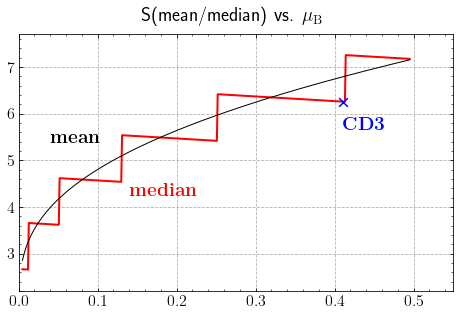

In [155]:
# make plot
#fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(7.88, 4.64)) # match current plot
#ax.plot(bs, s_meds, 'r-', linewidth=2, marker='.', mfc='black', mec='black', ms=1, zorder=10, label='median')
#ax.plot(bs, s_means, 'k-', linewidth=1, marker='.', mfc='black', mec='black', ms=1, zorder=11, label='mean')
ax.plot(bs, s_meds, 'r-', linewidth=2, zorder=10, label='median')
ax.plot(bs, s_means, 'k-', linewidth=1, ms=1, zorder=11, label='mean')
ax.scatter(b_CD3, s_med_CD3, s=75, c='blue', label='CD3', marker='x', zorder=12)
# text labels
plt.text(b_CD3[0], s_med_CD3[0] - 0.5, r"$\mathbf{CD3}$", rotation=0, size='large',
         verticalalignment='center', horizontalalignment='left', color='blue')

plt.text(b_med[0]+0.02, s_med[0] - 0.2, r"$\mathbf{median}$", rotation=0, size='large',
         verticalalignment='center', horizontalalignment='left', color='red')
plt.text(b_mean[0], s_mean[0] + 1.5, r"$\mathbf{mean}$", rotation=0, size='large',
         verticalalignment='center', horizontalalignment='left', color='black')

# plt.annotate('CD3', xy=(b_CD3[0], s_med_CD3[0] - 1.) ,
#              fontsize='large', rotation=0, fontweight='bold',
#              verticalalignment='center', horizontalalignment='center', color='blue')

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.02))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.set_xlim([0, 0.55])
ax.set_ylim([2.2, 7.7])
# ax.legend()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.tight_layout(rect=[0.073, 0.025, 0.92, 0.95])

#fig.suptitle(r'S(median) vs. $\mu_\mathrm{B}$'+'\n(Classical Ordering)');
# fig.suptitle(r'S(median) vs. $\mu_\mathrm{B}$');
fig.suptitle(r'S(mean/median) vs. $\mu_\mathrm{B}$');
fig.savefig('S_vs_muB.png', transparent=False)
fig.savefig('S_vs_muB.pdf', transparent=False)
fig.savefig('S_vs_muB.eps', format='eps', dpi=1200)

In [63]:
len(bs)

491